Shape: (9516837, 45)

Columns: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId          

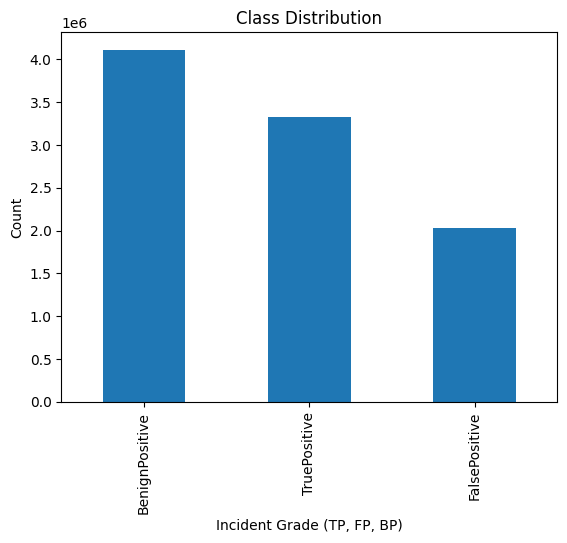


Missing values (top 20):
ResourceType         9509762
ActionGrouped        9460773
ActionGranular       9460773
ThreatFamily         9441956
EmailClusterId       9420025
AntispamDirection    9339535
Roles                9298686
SuspicionLevel       8072708
LastVerdict          7282572
MitreTechniques      5468386
IncidentGrade          51340
Timestamp                  0
Id                         0
EntityType                 0
DetectorId                 0
AlertTitle                 0
Category                   0
OrgId                      0
IncidentId                 0
AlertId                    0
dtype: int64

Missing values % (top 20):
ResourceType         99.925658
ActionGrouped        99.410897
ActionGranular       99.410897
ThreatFamily         99.213173
EmailClusterId       98.982729
AntispamDirection    98.136965
Roles                97.707736
SuspicionLevel       84.825536
LastVerdict          76.523030
MitreTechniques      57.460120
IncidentGrade         0.539465
Timestamp   

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")

# 1. Dataset overview
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
print(df.info())
print("\nSummary (numerical features):")
print(df.describe())

# 2. Check target distribution
print("\nTarget distribution:")
print(df['IncidentGrade'].value_counts())

df['IncidentGrade'].value_counts().plot(kind='bar', title="Class Distribution")
plt.xlabel("Incident Grade (TP, FP, BP)")
plt.ylabel("Count")
plt.show()

# 3. Missing values
print("\nMissing values (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nMissing values % (top 20):")
print((df.isnull().mean() * 100).sort_values(ascending=False).head(20))



In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ---------------------------
# 1. Missing values check
# ---------------------------
missing_report = (df.isnull().sum() / len(df)) * 100
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)
print("\n🔍 Missing Values (%):")
print(missing_report.head(15))

# ---------------------------
# 2. Separate numeric and categorical cols
# ---------------------------
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include="object").columns

# ---------------------------
# 3. Impute missing values
# ---------------------------
imputer_num = SimpleImputer(strategy="median")
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("\n✅ Missing values after imputation:")
print(df.isnull().sum().sum(), "missing values left")

# ---------------------------
# 4. Encode target column
# ---------------------------
le = LabelEncoder()
df["IncidentGrade"] = le.fit_transform(df["IncidentGrade"])  
print("\n🎯 Target class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print(df["IncidentGrade"].value_counts())

# ---------------------------
# 5. Encode other categorical columns
# ---------------------------
for col in cat_cols:
    if col != "IncidentGrade":  # make sure we don't re-encode target
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

print("\n✅ Example categorical columns after encoding:")
print(df[cat_cols].head())

# ---------------------------
# 6. Timestamp feature engineering
# ---------------------------
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df = df.drop(columns=['Timestamp'])

print("\n✅ Timestamp transformed into new features: Hour, DayOfWeek, Month")
print(df[['Hour','DayOfWeek','Month']].head())



🔍 Missing Values (%):
ResourceType         99.925658
ActionGranular       99.410897
ActionGrouped        99.410897
ThreatFamily         99.213173
EmailClusterId       98.982729
AntispamDirection    98.136965
Roles                97.707736
SuspicionLevel       84.825536
LastVerdict          76.523030
MitreTechniques      57.460120
IncidentGrade         0.539465
dtype: float64

✅ Missing values after imputation:
0 missing values left

🎯 Target class mapping: {'BenignPositive': np.int64(0), 'FalsePositive': np.int64(1), 'TruePositive': np.int64(2)}
IncidentGrade
0    4162157
2    3322713
1    2031967
Name: count, dtype: int64

✅ Example categorical columns after encoding:
   Timestamp  Category  MitreTechniques  IncidentGrade  ActionGrouped  \
0      97116        10              705              2              0   
1     675782         7              705              1              0   
2     622390        10              864              1              0   
3     476585         1       

In [6]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=["IncidentGrade"])
y = df["IncidentGrade"]

# Stratified split to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)
print("\nTarget distribution in Train:")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution in Validation:")
print(y_val.value_counts(normalize=True))


Train shape: (7613469, 46) Validation shape: (1903368, 46)

Target distribution in Train:
IncidentGrade
0    0.437347
2    0.349140
1    0.213513
Name: proportion, dtype: float64

Target distribution in Validation:
IncidentGrade
0    0.437347
2    0.349141
1    0.213513
Name: proportion, dtype: float64


In [9]:
import lightgbm as lgb

# Prepare datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Faster training parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,       # higher learning rate → faster convergence
    'num_leaves': 31,           # smaller trees → faster
    'max_depth': 8,             # limit tree depth → faster
    'feature_fraction': 0.6,    # use fewer features per tree → faster
    'bagging_fraction': 0.7,    # subsample data → faster
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1
}

# Train with fewer rounds and early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=500,                     # reduced from 1000
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# Save model
model.save_model("lightgbm_incident_classifier_fast.txt")
print("✅ Model saved as 'lightgbm_incident_classifier_fast.txt'")



Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.385482	valid's multi_logloss: 0.385549
[100]	train's multi_logloss: 0.306192	valid's multi_logloss: 0.306252
[150]	train's multi_logloss: 0.267066	valid's multi_logloss: 0.267188
[200]	train's multi_logloss: 0.242916	valid's multi_logloss: 0.24311
[250]	train's multi_logloss: 0.225128	valid's multi_logloss: 0.225457
[300]	train's multi_logloss: 0.212905	valid's multi_logloss: 0.213299
[350]	train's multi_logloss: 0.201656	valid's multi_logloss: 0.202096
[400]	train's multi_logloss: 0.193041	valid's multi_logloss: 0.193569
[450]	train's multi_logloss: 0.185333	valid's multi_logloss: 0.185913
[500]	train's multi_logloss: 0.179068	valid's multi_logloss: 0.179745
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.179068	valid's multi_logloss: 0.179745
✅ Model saved as 'lightgbm_incident_classifier_fast.txt'


In [10]:
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
y_pred = y_pred_proba.argmax(axis=1)

In [11]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print(classification_report(y_val, y_pred, target_names=['BenignPositive', 'FalsePositive', 'TruePositive']))
print("Macro-F1 Score:", f1_score(y_val, y_pred, average='macro'))
print("Precision:", precision_score(y_val, y_pred, average='macro'))
print("Recall:", recall_score(y_val, y_pred, average='macro'))


                precision    recall  f1-score   support

BenignPositive       0.93      0.96      0.94    832432
 FalsePositive       0.94      0.89      0.91    406393
  TruePositive       0.95      0.94      0.94    664543

      accuracy                           0.94   1903368
     macro avg       0.94      0.93      0.93   1903368
  weighted avg       0.94      0.94      0.94   1903368

Macro-F1 Score: 0.9334837013678404
Precision: 0.9389015772956023
Recall: 0.9288408355314995


In [3]:
import pandas as pd

# Load raw data
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")

# (then repeat preprocessing: handle missing values, encode categoricals, create timestamp features, etc.)


In [6]:
# Check missing values in features
print("Missing values in features:", X.isnull().sum().sum())

# Check missing values in target
print("Missing values in target:", y.isnull().sum())


Missing values in features: 86755176
Missing values in target: 51340


In [7]:
# 1. Drop rows with missing target
mask = y.notnull()
X = X[mask]
y = y[mask]

print("After dropping missing target rows:", X.shape, y.shape)

# 2. Fill missing values in features
# Option A: Simple fill
X = X.fillna(-1)

# (Optional: You can use more advanced imputers later)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="most_frequent")  # or "median"
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values left in features:", X.isnull().sum().sum())


After dropping missing target rows: (9465497, 44) (9465497,)
Missing values left in features: 0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Train shape:", X_train.shape, " Validation shape:", X_val.shape)
print("Target distribution in Train:\n", y_train.value_counts(normalize=True))
print("Target distribution in Validation:\n", y_val.value_counts(normalize=True))


✅ Train shape: (7572397, 44)  Validation shape: (1893100, 44)
Target distribution in Train:
 IncidentGrade
BenignPositive    0.434295
TruePositive      0.351034
FalsePositive     0.214671
Name: proportion, dtype: float64
Target distribution in Validation:
 IncidentGrade
BenignPositive    0.434295
TruePositive      0.351034
FalsePositive     0.214671
Name: proportion, dtype: float64


In [ ]:
import joblib

# Save validation data
joblib.dump((X_val, y_val), "validation_data.pkl")

print("✅ Validation data saved!")

✅ Validation data saved!


In [15]:
print("Shape:", df.shape)
print(df.info())
print(df.describe())
print(df.columns.tolist())


Shape: (9516837, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  Ema

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import lightgbm as lgb
from xgboost import XGBClassifier

# ----------------------------
# 0. Preprocess Data for CV
# ----------------------------

# Drop rows with missing target
df = df.dropna(subset=["IncidentGrade"])

# Fill missing values in features
df = df.fillna(-1)

# Convert categorical/object columns to numeric codes
for col in df.select_dtypes(include="object").columns:
    if col != "IncidentGrade":  # don't touch target
        df[col] = df[col].astype("category").cat.codes

# Encode target labels into integers
le = LabelEncoder()
df["IncidentGrade"] = le.fit_transform(df["IncidentGrade"])

# Save mapping for reference
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
# ----------------------------
# 1. Prepare Features & Target
# ----------------------------
# Make sure df is your preprocessed dataset
# Take a 5% sample (~475k rows instead of 9.5M)
df_sample = df.sample(frac=0.05, random_state=42)

X = df_sample.drop(columns=["IncidentGrade"])
y = df_sample["IncidentGrade"]

# ----------------------------
# 2. Cross-validation setup
# ----------------------------
scorer = make_scorer(f1_score, average="weighted")  # weighted F1 for imbalance
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ----------------------------
# 3. Define Models
# ----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",
        num_class=3,
        learning_rate=0.1,
        num_leaves=64,
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=500,
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    )
}

# ----------------------------
# 4. Run Cross-validation
# ----------------------------
results = {}
# Run models
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=1)
    print(f"{name} F1 (weighted): {scores.mean():.4f} ± {scores.std():.4f}")

# ----------------------------
# 5. Compare Results
# ----------------------------
print("\n📊 Model Performance Summary:")
for name, scores in results.items():
    print(f"{name:20s} | F1 (weighted): {scores.mean():.4f} ± {scores.std():.4f}")


Class mapping: {'BenignPositive': np.int64(0), 'FalsePositive': np.int64(1), 'TruePositive': np.int64(2)}

🔹 Training Logistic Regression...
Logistic Regression F1 (weighted): 0.4497 ± 0.0010

🔹 Training Decision Tree...
Decision Tree F1 (weighted): 0.7775 ± 0.0001

🔹 Training Random Forest...
Random Forest F1 (weighted): 0.9292 ± 0.0005

🔹 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6520
[LightGBM] [Info] Number of data points in the train set: 315516, number of used features: 44
[LightGBM] [Info] Start training from score -0.830978
[LightGBM] [Info] Start training from score -1.542023
[LightGBM] [Info] Start training from score -1.048597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018646 seconds.
You can set `for

c:\Users\BERLIN SAMUEL RAJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\BERLIN SAMUEL RAJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\BERLIN SAMUEL RAJ\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (weighted): 0.9260 ± 0.0006

📊 Model Performance Summary:


In [2]:
import pandas as pd

# Replace with your actual file path
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")

# Check the first few rows
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, make_scorer, f1_score
import lightgbm as lgb

# ----------------------------
# 0. Load Dataset
# ----------------------------
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")
print("Dataset loaded. Shape:", df.shape)

# ----------------------------
# 1. Preprocess Data
# ----------------------------
df = df.dropna(subset=["IncidentGrade"])
df = df.fillna(-1)

# Convert object columns to numeric codes
for col in df.select_dtypes(include="object").columns:
    if col != "IncidentGrade":
        df[col] = df[col].astype("category").cat.codes

# Encode target
le = LabelEncoder()
df["IncidentGrade_enc"] = le.fit_transform(df["IncidentGrade"])
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ----------------------------
# 2. Take a 5% Sample for Tuning (memory efficient)
# ----------------------------
df_sample = df.sample(frac=0.05, random_state=42)
X = df_sample.drop(columns=["IncidentGrade", "IncidentGrade_enc"]).astype(np.float32)
y = df_sample["IncidentGrade_enc"]

# ----------------------------
# 3. Train/Validation Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 4. Define LightGBM Model with Class Weights
# ----------------------------
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    class_weight='balanced',  # handles imbalance automatically
    random_state=42,
    n_jobs=-1
)

# ----------------------------
# 5. Hyperparameter Randomized Search (memory-efficient)
# ----------------------------
param_dist = {
    'num_leaves': [31, 64, 128],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 500, 1000],
    'max_depth': [6, 10, 15]
}

scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=5,  # fewer random trials
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ----------------------------
# 6. Train Model
# ----------------------------
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best macro-F1 (CV):", random_search.best_score_)

# ----------------------------
# 7. Evaluate on Validation Set
# ----------------------------
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)

print("\n📊 Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# ----------------------------
# 8. Optional: Retrain on Full Dataset Later
# ----------------------------
# After tuning, you can train the best parameters on the full dataset:
# X_full = df.drop(columns=["IncidentGrade", "IncidentGrade_enc"]).astype(np.float32)
# y_full = df["IncidentGrade_enc"]
# final_model = lgb.LGBMClassifier(**random_search.best_params_, objective='multiclass', num_class=len(le.classes_), class_weight='balanced', random_state=42, n_jobs=-1)
# final_model.fit(X_full, y_full)




Dataset loaded. Shape: (9516837, 45)
Class mapping: {'BenignPositive': np.int64(0), 'FalsePositive': np.int64(1), 'TruePositive': np.int64(2)}
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6468
[LightGBM] [Info] Number of data points in the train set: 378620, number of used features: 44
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best params: {'num_leaves': 64, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05}
Best macro-F1 (CV): 0.9322858341605922

📊 Validation Set Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.96      0.94      0.95     4

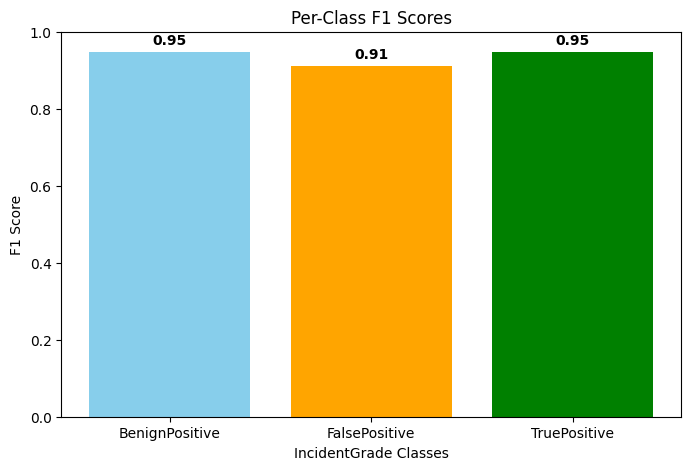

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Compute per-class F1 scores
f1_per_class = f1_score(y_val, y_val_pred, average=None)
classes = le.classes_

# Create bar plot
plt.figure(figsize=(8,5))
plt.bar(classes, f1_per_class, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title("Per-Class F1 Scores")
plt.ylabel("F1 Score")
plt.xlabel("IncidentGrade Classes")
for i, v in enumerate(f1_per_class):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


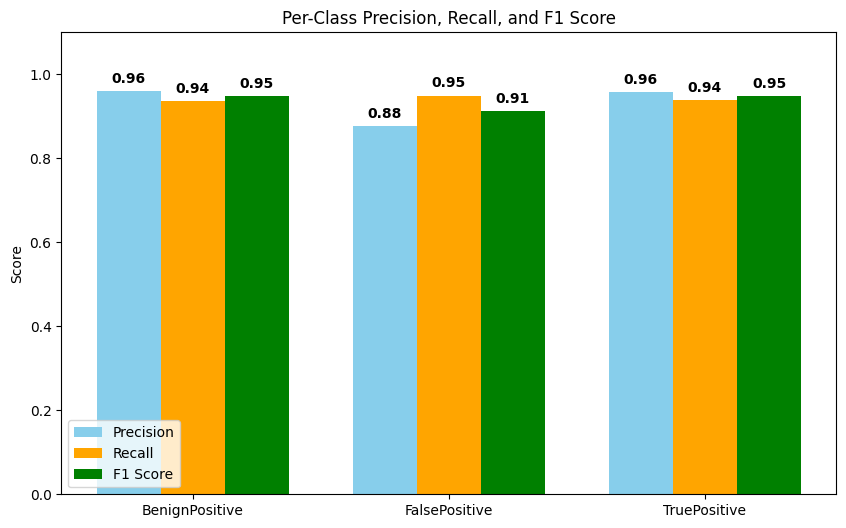

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute per-class metrics
classes = le.classes_
precision_per_class = precision_score(y_val, y_val_pred, average=None)
recall_per_class = recall_score(y_val, y_val_pred, average=None)
f1_per_class = f1_score(y_val, y_val_pred, average=None)

x = np.arange(len(classes))  # the label locations
width = 0.25  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width, precision_per_class, width, label='Precision', color='skyblue')
plt.bar(x, recall_per_class, width, label='Recall', color='orange')
plt.bar(x + width, f1_per_class, width, label='F1 Score', color='green')

# Add text labels on top of bars
for i in range(len(classes)):
    plt.text(i - width, precision_per_class[i]+0.02, f"{precision_per_class[i]:.2f}", ha='center', fontweight='bold')
    plt.text(i, recall_per_class[i]+0.02, f"{recall_per_class[i]:.2f}", ha='center', fontweight='bold')
    plt.text(i + width, f1_per_class[i]+0.02, f"{f1_per_class[i]:.2f}", ha='center', fontweight='bold')

plt.xticks(x, classes)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, and F1 Score")
plt.legend()
plt.show()


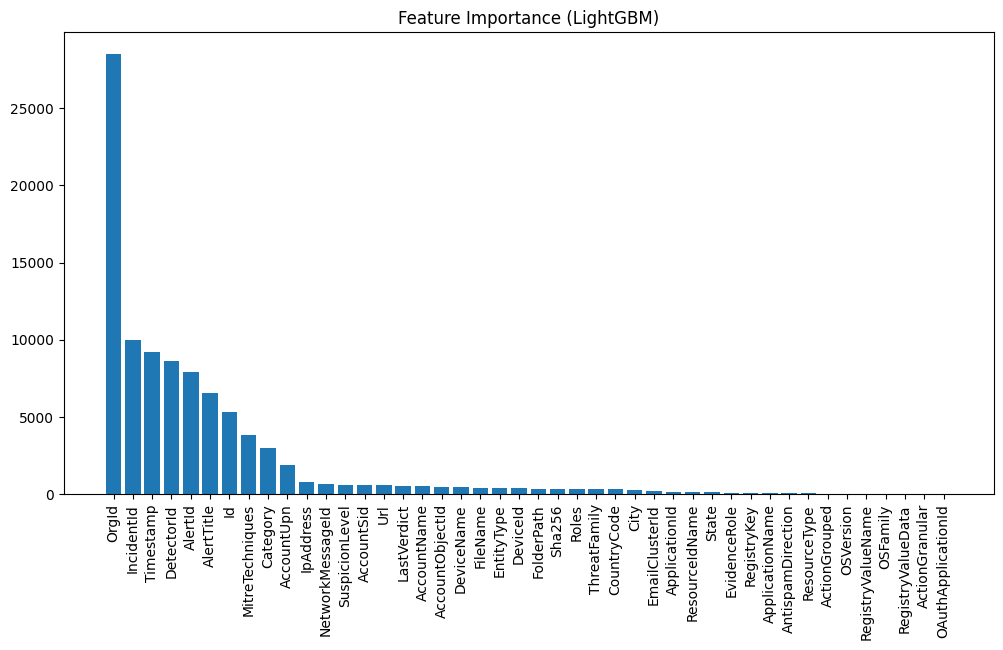

In [7]:
import matplotlib.pyplot as plt

# Feature importance from the best model
importance = best_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(importance)), importance[sorted_idx], tick_label=[feature_names[i] for i in sorted_idx])
plt.xticks(rotation=90)
plt.title("Feature Importance (LightGBM)")
plt.show()


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")

# Drop missing target and fill missing features
df = df.dropna(subset=["IncidentGrade"]).fillna(-1)

# Encode categorical features
for col in df.select_dtypes(include="object").columns:
    if col != "IncidentGrade":
        df[col] = df[col].astype("category").cat.codes

# Encode target
le = LabelEncoder()
df["IncidentGrade_enc"] = le.fit_transform(df["IncidentGrade"])

# Features & target
X = df.drop(columns=["IncidentGrade", "IncidentGrade_enc"]).astype('float32')
y = df["IncidentGrade_enc"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("X_val shape:", X_val.shape)

X_val shape: (1893100, 44)


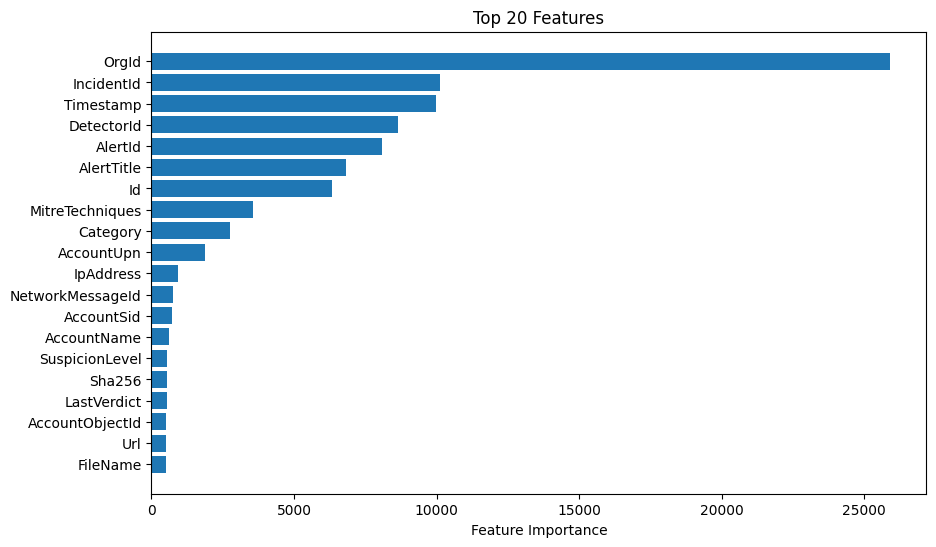

In [15]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# 1. Take a sample for feature importance (memory-efficient)
# ----------------------------
X_sample = X_train.sample(frac=0.1, random_state=42)
y_sample = y_train.loc[X_sample.index]

# ----------------------------
# 2. Recreate the best model with your tuned parameters
# Replace these with your actual best params from RandomizedSearchCV
best_params = {
    'num_leaves': 64,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 10,
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

best_model = lgb.LGBMClassifier(**best_params)

# ----------------------------
# 3. Fit the model on the sample
# ----------------------------
best_model.fit(X_sample, y_sample)

# ----------------------------
# 4. Plot Feature Importance
# ----------------------------
importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'].head(20), importance_df['importance'].head(20))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

# Load and preprocess
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")
df = df.dropna(subset=["IncidentGrade"]).fillna(-1)
for col in df.select_dtypes(include="object").columns:
    if col != "IncidentGrade":
        df[col] = df[col].astype("category").cat.codes

# Encode target
le = LabelEncoder()
df["IncidentGrade_enc"] = le.fit_transform(df["IncidentGrade"])

# Take 5% sample to reduce memory usage
df_sample = df.sample(frac=0.05, random_state=42)
X = df_sample.drop(columns=["IncidentGrade", "IncidentGrade_enc"]).astype(np.float32)
y = df_sample["IncidentGrade_enc"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = lgb.LGBMClassifier(objective='multiclass', num_class=len(le.classes_), class_weight='balanced', n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = model.predict(X_val)

# Now confusion_matrix will work
cm = confusion_matrix(y_val, y_val_pred)
print(cm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6468
[LightGBM] [Info] Number of data points in the train set: 378620, number of used features: 44
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[[38630  1691   913]
 [  702 19127   422]
 [ 1046  1038 31086]]


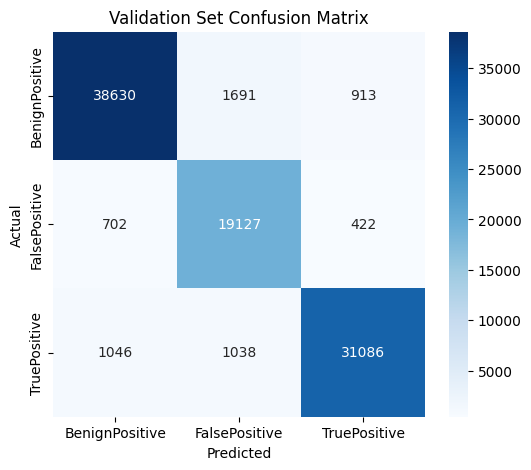

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Set Confusion Matrix")
plt.show()


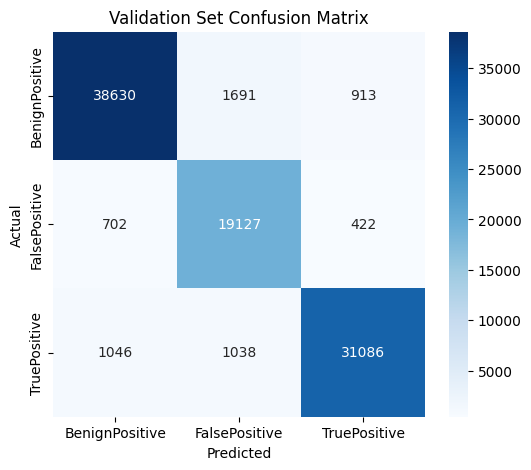

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, make_scorer, f1_score
import lightgbm as lgb

# ----------------------------
# 0. Load Training Data
# ----------------------------
df = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Train\GUIDE_Train.csv")
df = df.dropna(subset=["IncidentGrade"]).fillna(-1)

# Convert object columns to numeric codes
for col in df.select_dtypes(include="object").columns:
    if col != "IncidentGrade":
        df[col] = df[col].astype("category").cat.codes

# Encode target
le = LabelEncoder()
df["IncidentGrade_enc"] = le.fit_transform(df["IncidentGrade"])

# ----------------------------
# 1. Sample 5% of data for memory efficiency
# ----------------------------
df_sample = df.sample(frac=0.05, random_state=42)
X = df_sample.drop(columns=["IncidentGrade", "IncidentGrade_enc"]).astype(np.float32)
y = df_sample["IncidentGrade_enc"]

# ----------------------------
# 2. Train/Validation Split
# ----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 3. Define LightGBM model
# ----------------------------
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# ----------------------------
# 4. RandomizedSearchCV for hyperparameter tuning
# ----------------------------
param_dist = {
    'num_leaves': [31, 64, 128],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 500, 1000],
    'max_depth': [6, 10, 15]
}

scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist,
    n_iter=3,  # fewer iterations for faster run
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ----------------------------
# 5. Train model
# ----------------------------
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("Best params:", random_search.best_params_)
print("Best macro-F1 (CV):", random_search.best_score_)

# ----------------------------
# 6. Validate
# ----------------------------
y_val_pred = best_model.predict(X_val)
print("\nValidation Set Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# ----------------------------
# 7. Load Test Data and Predict
# ----------------------------
df_test = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Test\GUIDE_Test.CSV")

# Preprocess like training data
for col in df_test.select_dtypes(include="object").columns:
    df_test[col] = df_test[col].astype("category").cat.codes

# Ensure same feature columns as training
X_test = df_test.reindex(columns=X_train.columns, fill_value=-1).astype(np.float32)

# Predict
y_test_pred = best_model.predict(X_test)

print("Test Predictions Sample:", le.inverse_transform(y_test_pred)[:10])




Fitting 2 folds for each of 3 candidates, totalling 6 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6468
[LightGBM] [Info] Number of data points in the train set: 378620, number of used features: 44
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best params: {'num_leaves': 64, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05}
Best macro-F1 (CV): 0.9322858341605922

Validation Set Report:
                precision    recall  f1-score   support

BenignPositive       0.96      0.94      0.95     41234
 FalsePositive       0.88      0.95      0.91     20251
  TruePositive       0.96      0.94      0.95     33170

      accuracy                           0.

In [23]:
import joblib

# ----------------------------
# 1. Save the trained model
# ----------------------------
model_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\best_lgb_model.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved at: {model_path}")

# ----------------------------
# 2. Later, you can load it
# ----------------------------
loaded_model = joblib.load(model_path)
print("Model loaded successfully.")

# ----------------------------
# 3. Predict using loaded model
# ----------------------------
y_test_pred = loaded_model.predict(X_test)
print("Test Predictions Sample:", y_test_pred[:10])


Model saved at: D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\best_lgb_model.pkl
Model loaded successfully.
Test Predictions Sample: [0 0 1 1 0 2 0 0 1 0]


In [24]:
import pandas as pd

# If your test data has an ID column, include it; otherwise just index
df_predictions = pd.DataFrame({
    "ID": df_test.index,      # or replace with actual ID column if exists
    "Predicted_IncidentGrade": le.inverse_transform(y_test_pred)
})

# Save to CSV
output_path = r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\test_predictions.csv"
df_predictions.to_csv(output_path, index=False)

print(f"Predictions saved to: {output_path}")


Predictions saved to: D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\test_predictions.csv



Top 10 Important Features:
            Feature  Importance
1             OrgId       28484
2        IncidentId        9973
4         Timestamp        9237
5        DetectorId        8637
3           AlertId        7886
6        AlertTitle        6539
0                Id        5340
8   MitreTechniques        3849
7          Category        3003
18       AccountUpn        1866


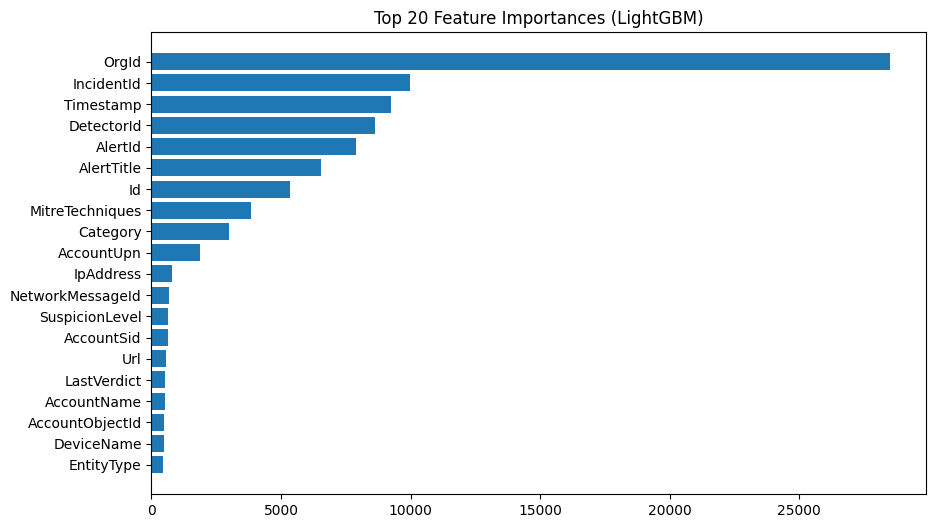


Running SHAP on 5000 validation samples...


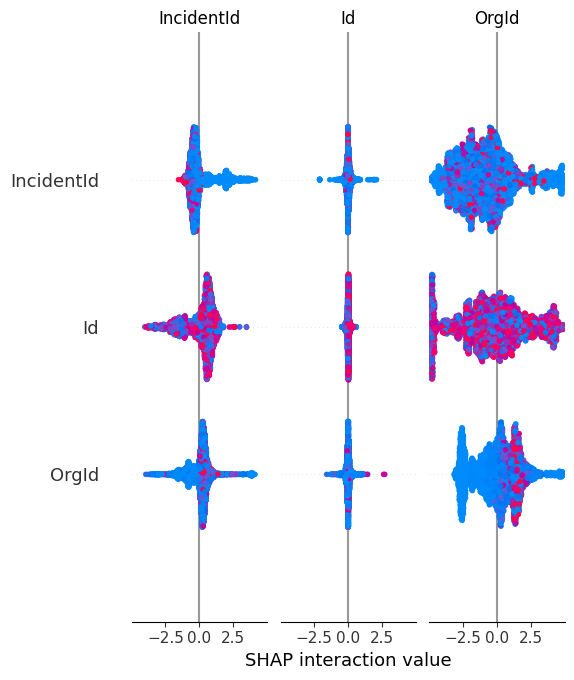

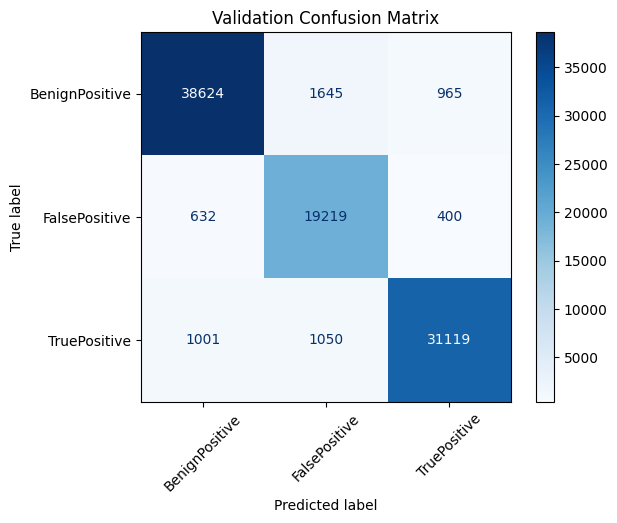


Error Analysis:
Correct Predictions: 88962
Misclassifications: 5693

Final Test Set Report:
                precision    recall  f1-score   support

BenignPositive       0.93      0.87      0.90    443495
 FalsePositive       0.78      0.89      0.83    228279
  TruePositive       0.91      0.91      0.91    376801

      accuracy                           0.89   1048575
     macro avg       0.87      0.89      0.88   1048575
  weighted avg       0.89      0.89      0.89   1048575



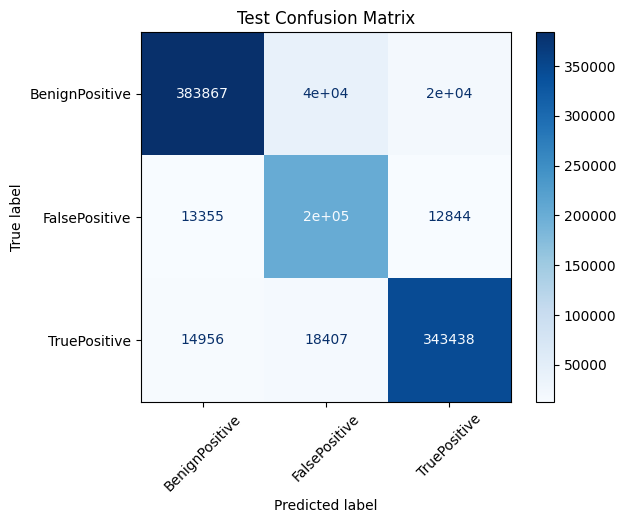


✅ Predictions saved to Test_Predictions.csv

Baseline Validation Accuracy (Random Guess): 0.3333333333333333
Validation Macro-F1 (Best Model): 0.9322858341605922


In [26]:
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ----------------------------
# 8. Feature Importance (Model-Specific)
# ----------------------------
importances = best_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(feat_imp.head(10))

# Plot top 20
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"].head(20), feat_imp["Importance"].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()

# ----------------------------
# 9. SHAP for deeper interpretation (Optional: sample 5000)
# ----------------------------
sample_size = min(5000, X_val.shape[0])
X_val_sample = X_val.sample(sample_size, random_state=42)

print(f"\nRunning SHAP on {sample_size} validation samples...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample)

# Summary plot
shap.summary_plot(shap_values, X_val_sample, feature_names=X_val_sample.columns)

# ----------------------------
# 10. Error Analysis
# ----------------------------
y_val_pred = best_model.predict(X_val)

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Validation Confusion Matrix")
plt.show()

errors = pd.Series(y_val != y_val_pred).value_counts()
print("\nError Analysis:")
print(f"Correct Predictions: {errors.get(False,0)}")
print(f"Misclassifications: {errors.get(True,0)}")

# ----------------------------
# 11. Final Evaluation on Test Set
# ----------------------------
df_test = pd.read_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\GUIDE_Test\GUIDE_Test.CSV")

# Preprocess test data
for col in df_test.select_dtypes(include="object").columns:
    df_test[col] = df_test[col].astype("category").cat.codes

# Align features with training
X_test = df_test.reindex(columns=X_train.columns, fill_value=-1).astype(np.float32)

y_test_pred = best_model.predict(X_test)

# If test labels exist
if "IncidentGrade" in df_test.columns:
    # Already numeric → use directly
    y_test_true = df_test["IncidentGrade"].astype(int)
    
    print("\nFinal Test Set Report:")
    print(classification_report(y_test_true, y_test_pred, target_names=le.classes_))

    cm_test = confusion_matrix(y_test_true, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Test Confusion Matrix")
    plt.show()
else:
    print("\n⚠️ Test labels not found. Only predictions generated.")

# ----------------------------
# 12. Save Predictions
# ----------------------------
df_test["Predicted_IncidentGrade"] = le.inverse_transform(y_test_pred)
df_test.to_csv(r"D:\CERTIFICATIONS\GUVI\Capestone Project-4 (CyberSecurity)\Test_Predictions.csv", index=False)
print("\n✅ Predictions saved to Test_Predictions.csv")

# ----------------------------
# 13. Compare with Baseline
# ----------------------------
print("\nBaseline Validation Accuracy (Random Guess):", 1/len(le.classes_))
print("Validation Macro-F1 (Best Model):", random_search.best_score_)
